# Tidy Tuesday - Predicting boardgame ratings (Part 1)


In part 1, we examined the R Tidy Tuesday dataset from January 2022, which was a dataset of boardgame ratings from BoardGameGeek.com. In this notebook, we will attempt to predict boardgame ratings based on characteristics of the games.

In part 1, we split our data into a training and a test dataset. First, let's load the training data.

In [110]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:


train_data = pd.read_csv('data/train.csv')
train_data.head()

,Unnamed: 0,num_x,id,name,year,rank,average,bayes_average,users_rated,url,...,dsgnr_Hans van Tol,dsgnr_Joris Wiersinga,dsgnr_Justin D. Jacobson,dsgnr_Reiner Stockhausen,dsgnr_Brian Train,dsgnr_Chih-Fan Chen,dsgnr_Christian Fiore,dsgnr_Chris Perello,dsgnr_Philip duBarry,dsgnr_Serge Laget
0,0,7685,24996,Start Player: A Kinda Collectible Card Game,2006,7686,6.51,5.594,182,/boardgame/24996/start-player-kinda-collectibl...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2856,37165,"Warhammer 40,000 (Fifth Edition)",2008,2857,6.73,5.939,1080,/boardgame/37165/warhammer-40000-fifth-edition,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3096,17804,Dungeons & Dragons Basic Game,2004,3097,6.81,5.897,827,/boardgame/17804/dungeons-dragons-basic-game,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4236,252997,Mapmaker: The Gerrymandering Game,2019,4237,6.76,5.762,497,/boardgame/252997/mapmaker-gerrymandering-game,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,13847,266421,Ubongo! Fun-Size Edition,2018,13848,6.35,5.524,51,/boardgame/266421/ubongo-fun-size-edition,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




### Preparing the data

LightGBM does not support "special" characters in feature names, so let's also remove any such characters from the column names. Specifically, let's convert any non-alphabetic, non-underscore characters to underscores.


In [52]:
col_names = train_data.columns.to_list()
import re
def r_underscore(x):
    return re.sub(r"[^a-zA-Z_]+", "_", x)

train_data.columns = list(map(r_underscore, col_names))
train_data.head()

,Unnamed_,num_x,id,name,year,rank,average,bayes_average,users_rated,url,...,dsgnr_Hans_van_Tol,dsgnr_Joris_Wiersinga,dsgnr_Justin_D_Jacobson,dsgnr_Reiner_Stockhausen,dsgnr_Brian_Train,dsgnr_Chih_Fan_Chen,dsgnr_Christian_Fiore,dsgnr_Chris_Perello,dsgnr_Philip_duBarry,dsgnr_Serge_Laget
0,0,7685,24996,Start Player: A Kinda Collectible Card Game,2006,7686,6.51,5.594,182,/boardgame/24996/start-player-kinda-collectibl...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2856,37165,"Warhammer 40,000 (Fifth Edition)",2008,2857,6.73,5.939,1080,/boardgame/37165/warhammer-40000-fifth-edition,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3096,17804,Dungeons & Dragons Basic Game,2004,3097,6.81,5.897,827,/boardgame/17804/dungeons-dragons-basic-game,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4236,252997,Mapmaker: The Gerrymandering Game,2019,4237,6.76,5.762,497,/boardgame/252997/mapmaker-gerrymandering-game,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,13847,266421,Ubongo! Fun-Size Edition,2018,13848,6.35,5.524,51,/boardgame/266421/ubongo-fun-size-edition,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's drop unneeded columns. Because we already have a large number of column names representing the mechanic and designer dummy variables, we need to select the relevant columns programmatically. Columns for designer dummies start with "dsgnr_" and columns for mechanic dummies start with "mech_".

In [118]:
column_names = train_data.columns.to_list()
mech_columns = [s for s in column_names if s.startswith('mech_')]
dsgnr_columns = [s for s in column_names if s.startswith('dsgnr_')]


# for column in column_names:
#     print(column)
other_columns = ['yearpublished', 'minplayers', 'maxplayers', 'minplaytime', 'maxplaytime']
X_columns = other_columns + mech_columns + dsgnr_columns
X_df = train_data[X_columns].copy()
y_df = train_data[['average']]
# print(X_df.head(), y_df.head())

In [119]:
X_df.head()

,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,mech_Dice_Rolling,mech_Modular_Board,mech_Variable_Player_Powers,mech_Cooperative_Game,mech_Role_Playing,...,dsgnr_Hans_van_Tol,dsgnr_Joris_Wiersinga,dsgnr_Justin_D_Jacobson,dsgnr_Reiner_Stockhausen,dsgnr_Brian_Train,dsgnr_Chih_Fan_Chen,dsgnr_Christian_Fiore,dsgnr_Chris_Perello,dsgnr_Philip_duBarry,dsgnr_Serge_Laget
0,2006,2,999,1,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008,2,12,60,60,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,2,5,90,90,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,1,4,30,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,1,4,15,15,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Baseline: Simple mean

Our evaluation metric will be the root mean squared error in average rating. Before we start modeling, let's see what RMSE we get when we predict using the mean average rating across the training dataset.

In [120]:
n_folds = 5
cv = KFold(n_folds, shuffle = True, random_state = 20230609)

lgbm_reg_params = {"objective": "regression"}

errors = []

for i, (train_idx, val_idx) in enumerate(cv.split(X_df, y_df)):
    X_train_fold, y_train_fold = X_df.loc[train_idx], y_df.loc[train_idx]
    X_val_fold, y_val_fold = X_df.loc[val_idx], y_df.loc[val_idx]
    
    mean_y = np.mean(y_train_fold.iloc[:,0])
    
    preds = mean_y * np.ones(y_val_fold.shape)
    
    error = np.sqrt(mean_squared_error(y_val_fold, preds))
    errors.append(error)
    
baseline_error = np.mean(errors)
print(baseline_error)

0.9275094328607072


## Gradient boosting

Next, let's try gradient boosting, using Light GBM. First, let's see how well this does using default hyperparameters.

In [121]:
n_folds = 5
cv = KFold(n_folds, shuffle = True, random_state = 20230609)

lgbm_reg_params = {"objective": "regression"}

errors = []

for i, (train_idx, val_idx) in enumerate(cv.split(X_df, y_df)):
    X_train_fold, y_train_fold = X_df.loc[train_idx], y_df.loc[train_idx]
    X_val_fold, y_val_fold = X_df.loc[val_idx], y_df.loc[val_idx]
    
    lgbm_reg = lgb.LGBMRegressor(**lgbm_reg_params)
    lgbm_reg.fit(X_train_fold, y_train_fold)
    
    lgbm_reg_preds = lgbm_reg.predict(X_val_fold)
    
    error = np.sqrt(mean_squared_error(y_val_fold, lgbm_reg_preds))
    errors.append(error)
    
lgbm_default_error = np.mean(errors)
print(lgbm_default_error)

0.6554130259125734


RMSE of 0.655 is an improvement on 0.93. Let's plot actual average rating against predict average rating to see if that is informative.

(For convenience, we can use the predictions based on the last of 5 CV models for this.)


<AxesSubplot:xlabel='average', ylabel='pred'>

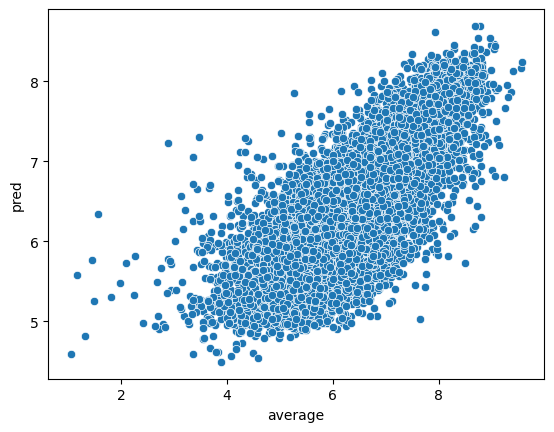

In [122]:
all_preds = lgbm_reg.predict(X_df)
df_plot = X_df.copy()
df_plot['average'] = y_df['average']
df_plot['pred'] = all_preds

# df_plot.head()
sns.scatterplot(data = df_plot, x = 'average', y = 'pred')

Now let's see if hyperparameter tuning can improve our predictions.

Let's see what variables are playing a role. Suppose we wanted to use this model in production and had to cap the model at 10 explanatory variables? Which variables would be select and how would the model perform?